#  기존 모델에 노이즈이미지 적용하기  
   + 배경이 존재하는 이미지 및 훈련 데이터셋과는 다른 유형의 이미지 적용

## 1. ResNet 구조 정의

In [1]:
#러즈넷 아키텍처
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import transforms

# Residual Block 구조 정의
class BasicBlock(nn.Module):
    mul = 1
    def __init__(self, in_planes, out_planes, stride=1):
        super(BasicBlock, self).__init__()
        
        # stride를 통해 조정
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        
        # stride = 1, padding = 1
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        
        # x를 그대로 더해주기 위함
        self.shortcut = nn.Sequential()
        
        # 만약 size가 안맞아 합연산이 불가하다면, 연산 가능하도록 모양을 맞춰줌
        if stride != 1: 
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes)
            )
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x) # 필요에 따라 레이어 Skip
        out = F.relu(out)
        return out
    
class BottleNeck(nn.Module):
    mul = 4
    def __init__(self, in_planes, out_planes, stride=1):
        super(BottleNeck, self).__init__()
        
        #첫 Convolution은 너비와 높이 downsampling
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        
        self.conv3 = nn.Conv2d(out_planes, out_planes*self.mul, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes*self.mul)
        
        self.shortcut = nn.Sequential()
        
        if stride != 1 or in_planes != out_planes*self.mul:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes*self.mul, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes*self.mul)
            )
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out           

    
    
    
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=5): #num_blocks = [3,4,6,3], block = bottleneck
        super(ResNet, self).__init__()
        #RGB 3개채널에서 64개의 Kernel 사용
        self.in_planes = 64
        
        # Resnet 논문 구조 그대로 구현
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=7, stride=2, padding = 3)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self.make_layer(block, 64, num_blocks[0], stride=1) #3블럭
        self.layer2 = self.make_layer(block, 128, num_blocks[1], stride=2) #4블럭
        self.layer3 = self.make_layer(block, 256, num_blocks[2], stride=2) #6블럭
        self.layer4 = self.make_layer(block, 512, num_blocks[3], stride=2) #3블럭
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(512 * block.mul, num_classes)
        
    def make_layer(self, block, out_planes, num_blocks, stride):
        # layer 앞부분에서만 크기를 절반으로 줄이므로, 아래와 같은 구조
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for i in range(num_blocks):
            layers.append(block(self.in_planes, out_planes, strides[i]))
            self.in_planes = block.mul * out_planes
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.maxpool1(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out,1)
        out = self.linear(out) #완전연결계층
        return out
    

def ResNet50():
    return ResNet(BottleNeck, [3, 4, 6, 3]) #블럭 수 설정

## 2. DataLoader 정의

In [2]:
class CustomImageDataset(Dataset):
    def read_data_set(self):

        all_img_files = []
        all_labels = []

        class_names = os.walk(self.data_set_path).__next__()[1]

        for index, class_name in enumerate(class_names):
            label = index
            img_dir = os.path.join(self.data_set_path, class_name)
            img_files = os.walk(img_dir).__next__()[2]

            for img_file in img_files:
                img_file = os.path.join(img_dir, img_file)
                img = Image.open(img_file)
                if img is not None:
                    all_img_files.append(img_file)
                    all_labels.append(label)

        return all_img_files, all_labels, len(all_img_files), len(class_names)

    def __init__(self, data_set_path, transforms=None):
        self.data_set_path = data_set_path
        self.image_files_path, self.labels, self.length, self.num_classes = self.read_data_set()
        self.transforms = transforms

    def __getitem__(self, index):
        image = Image.open(self.image_files_path[index])
        image = image.convert("RGB")

        if self.transforms is not None:
            image = self.transforms(image)

        return {'image': image, 'label': self.labels[index] }

    def __len__(self):
        return self.length

## 3. 테스트 이미지(노이즈 이미지) 불러오기
    * DeepFashion Dataset 및 구글 검색 이미지 사용

In [3]:
#main (test에 필요한 요소로만 구성)
transforms_test = transforms.Compose([transforms.Resize((128, 128),interpolation=Image.AFFINE),
                                      transforms.ToTensor()])

test_data_set = CustomImageDataset(data_set_path="./noise_data", transforms=transforms_test)
test_loader = DataLoader(test_data_set, batch_size=5, shuffle=True)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

custom_model = ResNet50().to(device) #num_class는 5로 설정

## 4. 저장된 모델(기존 모델) 불러오기  

In [4]:
custom_model.load_state_dict(torch.load('./model/resnet_e20.pth')) #모델 불러오기 (기존 모델)

<All keys matched successfully>

## 5. Test를 통한 정확도 측정

In [5]:
# Test 
custom_model.eval()  # 모델 평가모드
with torch.no_grad():
    correct = 0
    total = 0
    for item in test_loader:
        images = item['image'].to(device) #원본 이미지
        labels = item['label'].to(device) #라벨 값
        
        outputs = custom_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += len(labels)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the {} test images: {} %'.format(total, 100 * correct / total))

Test Accuracy of the model on the 20 test images: 40.0 %


## 6. 결과 이미지 확인 및 분석

In [11]:
predicted

tensor([0, 1, 0, 1, 1], device='cuda:0')

In [12]:
labels

tensor([1, 0, 0, 1, 1], device='cuda:0')

### [1] 예측 : Accessories  / 정답 : Apparel

tensor(0, device='cuda:0')
tensor(1, device='cuda:0')


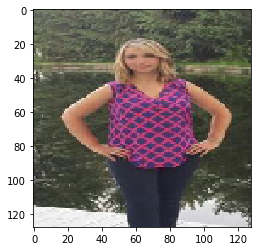

In [6]:
# 첫번째 사진

first = images[0].cpu().squeeze(0) #4차원 -> 3차원
trans = transforms.ToPILImage()
first = trans(first)

from matplotlib import pyplot as plt

print(predicted[0]) # 예측 - Accessories
print(labels[0]) # 정답 - Apparel
plt.imshow(first)
plt.show()

### [2] 예측 : Apparel  / 정답 : Accessories

tensor(1, device='cuda:0')
tensor(0, device='cuda:0')


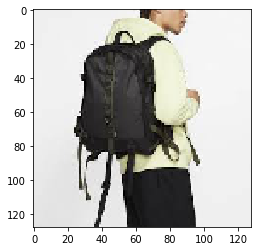

In [13]:
# 두번째 사진

second = images[1].cpu().squeeze(0) #4차원 -> 3차원
trans = transforms.ToPILImage()
second = trans(second)

print(predicted[1]) # 예측 - Apparel
print(labels[1]) # 정답 - Accessories
plt.imshow(second)
plt.show()

### [3] 예측 : Accessories  / 정답 : Accessories

tensor(0, device='cuda:0')
tensor(0, device='cuda:0')


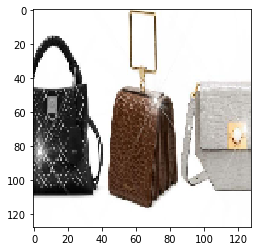

In [8]:
# 세번째 사진

third = images[2].cpu().squeeze(0) #4차원 -> 3차원
trans = transforms.ToPILImage()
third = trans(third)

print(predicted[2]) # 예측 - Accessories 
print(labels[2]) # 정답 - Accessories
plt.imshow(third)
plt.show()

### [4] 예측 : Apparel  / 정답 : Apparel

tensor(1, device='cuda:0')
tensor(1, device='cuda:0')


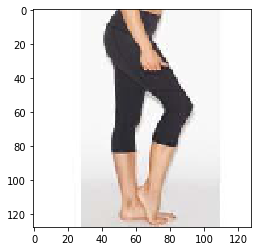

In [9]:
# 네번째 사진

fourth = images[3].cpu().squeeze(0) #4차원 -> 3차원
trans = transforms.ToPILImage()
fourth = trans(fourth)

print(predicted[3]) # 예측 - Apparel
print(labels[3]) # 정답 - Apparel
plt.imshow(fourth)
plt.show()

### [5] 예측 : Apparel  / 정답 : Accessories

tensor(1, device='cuda:0')
tensor(1, device='cuda:0')


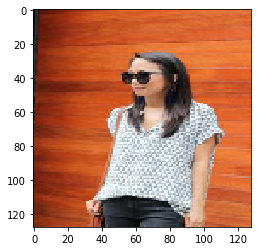

In [10]:
# 다섯번째 사진

fifth = images[4].cpu().squeeze(0) #4차원 -> 3차원
trans = transforms.ToPILImage()
fifth = trans(fifth)

print(predicted[4]) # 예측 - Apparel
print(labels[4]) # 정답 - Accessories
plt.imshow(fifth)
plt.show()